In [1]:
import numpy as np
import cv2
from PIL import Image
from skimage.morphology import skeletonize
from skimage import img_as_bool, io, color
from skimage.morphology import skeletonize, binary_erosion
from skimage import img_as_bool, io, color
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from skimage.filters import gabor
from skimage.morphology import thin
import os
import math

In [9]:
# normalize 
def preprocess_and_skeletonize_image(image_path, resize_factor=0.9, threshold=128):
    # Load and downsize the image
    with Image.open(image_path) as img:
        original_width, original_height = img.size
        new_width = int(original_width * resize_factor)
        new_height = int(original_height * resize_factor)
        img_resized = img.resize((new_width, new_height))

    # Normalize the resized image
    image_array = np.asarray(img_resized).astype('float32')
    mean = image_array.mean()
    std = image_array.std()
    normalized_image_array = (image_array - mean) / std

    # Convert to black and white
    normalized_image = Image.fromarray(np.uint8(normalized_image_array))
    bw_image = normalized_image.convert('L').point(lambda x: 255 if x > threshold else 0, '1')

    # Convert skeleton (True for text) back to white (255) for visualization
    skeleton_image = np.where(skeleton, 255, 0).astype(np.uint8)

    # Convert the skeletonized image back to a PIL Image for visualization
    skeleton_image_pil = Image.fromarray(skeleton_image)

    return skeleton_image_pil

# Example usage
image_path = 'w0001_s01_pLND_r01.png'  # Update this path to your actual image path
skeleton_image = preprocess_and_skeletonize_image(image_path)
skeleton_image.show()

/var/folders/_d/bgc0ml897834kf4fkff32r300000gn/T/ipykernel_33797/43441281.py:17: RuntimeWarning: invalid value encountered in cast
  normalized_image = Image.fromarray(np.uint8(normalized_image_array))


NameError: name 'skeleton' is not defined

In [ ]:
## Thinning Code 
'''
Tested on one image, eventually removed from preprocessing routine as thinning removed 
critical information regarding pen stroke style and thickness.
'''
image_path = 'w0001_s01_plND_r01.jpeg'

def read_jpeg_binary(path, cutoff_adjust=0, clean=True, crop=True, inversion=False):
    # Load image in grayscale
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    # Binarize the image using Otsu's method
    _, binarized_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Adjust threshold if cutoff_adjust is not 0
    if cutoff_adjust != 0:
        adjusted_thresh = _ + (_ * cutoff_adjust)
        _, binarized_img = cv2.threshold(img, adjusted_thresh, 255, cv2.THRESH_BINARY)
    
    # Invert image if inversion is True
    if inversion:
        binarized_img = cv2.bitwise_not(binarized_img)
    
    # Clean the image by filling white pixels with 7 or 8 black neighbors
    if clean:
        kernel = np.ones((3,3),np.uint8)
        binarized_img = cv2.morphologyEx(binarized_img, cv2.MORPH_CLOSE, kernel)
    
    # Crop the white space around the image
    if crop:
        coords = cv2.findNonZero(binarized_img)  # Find all non-zero points (text)
        x, y, w, h = cv2.boundingRect(coords)  # Find minimum spanning bounding box
        binarized_img = binarized_img[y:y+h, x:x+w]  # Crop the image
        
        # Optionally add a 1-pixel border around the cropped image
        binarized_img = cv2.copyMakeBorder(binarized_img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    
    # Convert image to binary format (0 and 1)
    binarized_img = (binarized_img / 255).astype(np.uint8)
    
    return binarized_img


image_path = 'w0001_s01_plND_r01.jpeg'
binary_image = read_jpeg_binary(image_path, inversion=True)
plt.imshow(binary_image, cmap='gray')
plt.show()
output_path = 'output.png'

plt.savefig(output_path)
plt.clf()


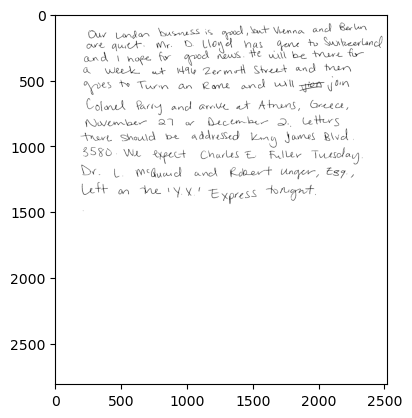

In [14]:
# reading and binarizing image
def read_and_binarize_image(path, invert=False):
    # Read the image in grayscale
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # Apply Otsu's thresholding
    _, binarized_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Optionally invert the image
    if invert:
        binarized_img = cv2.bitwise_not(binarized_img)
        
    return binarized_img

binarized_img = read_and_binarize_image(image_path)
plt.imshow(binarized_img, cmap='gray')
plt.show()


In [15]:
# Ensure img is a binary image with characters in white (255) and background in black (0)
# Find contours of the character
def extract_basic_features(img):
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the largest contour corresponds to the character
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    
    aspect_ratio = float(w) / h
    area = cv2.contourArea(cnt)
    
    M = cv2.moments(cnt)
    centroid_x = int(M["m10"] / M["m00"])
    centroid_y = int(M["m01"] / M["m00"])
    
    features = {
        "aspect_ratio": aspect_ratio,
        "area": area,
        "centroid": (centroid_x, centroid_y)
    }
    
    return features

features = extract_basic_features(binarized_img)
print(features)

{'aspect_ratio': 0.8977920227920227, 'area': 7073640.0, 'centroid': (1260, 1403)}


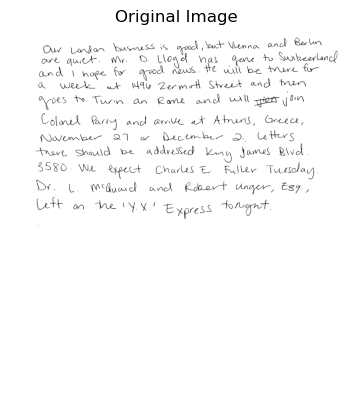

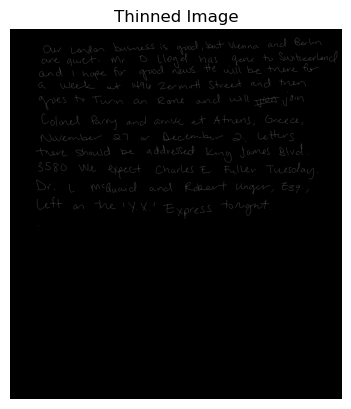

In [17]:
def read_and_binarize_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    _, binarized_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binarized_img

def thin_image(img):
    # Ensure the image is boolean for skeletonize
    binary_image = img < 128  # Assuming dark text on light background
    thinned_image = skeletonize(binary_image)
    return thinned_image.astype(np.uint8) * 255

def process_handwriting(thinned_img):
    # Placeholder for processing logic; would include identifying nodes, paths, etc.
    # This could involve custom logic or leveraging libraries for graph analysis.
    # Let's assume it returns a dict with 'nodes' and other relevant details.
    return {'nodes': []}  # Simplified placeholder return

def plot_image(img, title="Image"):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def process_document(path):
    doc = {}
    doc['image'] = read_and_binarize_image(path)
    doc['thin'] = thin_image(doc['image'])
    doc['process'] = process_handwriting(doc['thin'])
    doc['docname'] = os.path.basename(path).replace('.png', '').replace('.PNG', '')
    return doc


doc = process_document(image_path)
plot_image(doc['image'], "Original Image")
plot_image(doc['thin'], "Thinned Image")


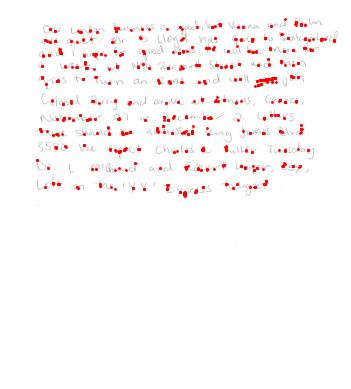

[  72   97   98 ... 1406 1407 1415]
[2086 2171 2170 ... 1325 1325 1328]
Average Distance Between Intersections: 346.89791555917645


In [30]:
# intra text intersections
def load_image(image_path):
    """Load an image."""
    return cv2.imread(image_path)

def binarize_image(image):
    """Convert an image to a binary format."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return binary_image

def apply_skeletonization(binary_image):
    """Apply skeletonization to a binary image."""
    binary_bool = binary_image > 0
    skeletonized_image = skeletonize(binary_bool)
    return skeletonized_image.astype(np.uint8)

def find_intersections(skeletonized_image):
    """Find intra-stroke intersections in a skeletonized image."""
    # Define a kernel to highlight potential intersection points
    kernel = np.array([[1, 2, 1], [2, 1, 2], [1, 2, 1]], dtype=np.uint8)
    filtered_image = cv2.filter2D(skeletonized_image, -1, kernel)
    
    # Potential intersections are where the convolution result is 10 or higher
    intersections = np.where(filtered_image >= 7, 1, 0)
    
    # Further refine to eliminate junctions and retain intra-stroke intersections
    refined_intersections = np.zeros_like(intersections)
    for y in range(1, intersections.shape[0] - 1):
        for x in range(1, intersections.shape[1] - 1):
            if intersections[y, x] == 1:
                refined_intersections[y, x] = 1
    
    return refined_intersections

def plot_intersections_on_image(original_image, intersections):
    """Plot the intersections as red points on the original image."""
    y_coords, x_coords = np.nonzero(intersections)
    
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.scatter(x_coords, y_coords, color='red', s=1)
    plt.axis('off')
    plt.show()
    
def calculate_average_distance(x_coords, y_coords):
    distances = np.sqrt(np.diff(x_coords)**2 + np.diff(y_coords)**2)
    average_distance = np.mean(distances)
    return average_distance


image_path = 'w0001_s01_plND_r01.png'
original_image = load_image(image_path)
binary_image = binarize_image(original_image)
skeletonized_image = apply_skeletonization(binary_image)
intersections = find_intersections(skeletonized_image)

# 'intersections' is your numpy array from detection process
plot_intersections_on_image(original_image, intersections)
y_coords, x_coords = np.nonzero(intersections)
print(y_coords)
print(x_coords)

average_distance = calculate_average_distance(x_coords, y_coords)
print(f"Average Distance Between Intersections: {average_distance}")

In [2]:
## BREAK APART INTO BY CHARACTER and LINE

def rotate_image(image, angle):
    """
        Rotates the given image by the input angle -- counter-clockwise direction
    """
    # create an tuple that contains height/2, width/2
    image_center = tuple(np.array(image.shape[1::-1]) / 2) 
    # rot_mat 2x3 rotation mattrix
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    # apply the affine transformation to the image
    # size of the output image image.shape[1::-1]
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def read_image(img_path):
    image = cv2.imread(img_path)

    scale_percent = 18  # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    rescaled_img = cv2.resize(image, dim, interpolation=cv2.INTER_AREA) 
    return image, rescaled_img  

def save_img(dir_path,filename,img):
    file_path = os.path.join(dir_path,filename)
    cv2.imwrite(file_path,img)

def find_text_angle(dilated_img,org_img):
    lines = cv2.HoughLinesP(dilated_img,rho=1,theta=np.pi/180,threshold=30,minLineLength=5,maxLineGap=20)

    nb_lines = len(lines)
    angle = 0

    for line in lines:
        x1,y1,x2,y2 = line[0]
        angle += math.atan2((y2-y1),(x2-x1)) 

    angle/=nb_lines

    rotated = rotate_image(org_img, angle-1)
    rot_dilated = rotate_image(dilated_img,angle-1)

    return rotated, rot_dilated
 
def extract_text_lines(img,output_dir):   
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 5)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 5, 5)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (16, 2))
    dilate = cv2.dilate(thresh, kernel, iterations=2)
    rotated,rot_dilated = find_text_angle(dilate,img)

    cnts = cv2.findContours(rot_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 2:
        cnts = cnts[0]
    else:
        cnts = cnts[1]

    lines_path = os.path.join(output_dir,'lines')  

    if not os.path.exists(lines_path):
        os.makedirs(lines_path)

    for line_idx, line in enumerate(cnts, start=-len(cnts)):
        x, y, w, h = cv2.boundingRect(line)
        roi = rotated[y:y + h, x:x + w]
        filename = 'line'+str(line_idx)+ '.jpg'
        save_img(lines_path,filename=filename,img=roi)
    
def extract_text_chars(img,output_dir):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 7)

    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 11)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 7))

    dilate = cv2.dilate(thresh, kernel, iterations=1)

    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 2:
        cnts = cnts[0]
    else:
        cnts = cnts[1]
    
    chars_path = os.path.join(output_dir,'chars')  

    if not os.path.exists(chars_path):
        os.makedirs(chars_path)
        
    for char_idx, character in enumerate(cnts, start=-len(cnts)):
        x, y, w, h = cv2.boundingRect(character)
        roi = img[y:y + h, x:x + w]
        filename = 'char'+str(char_idx)+ '.jpg'
        save_img(chars_path,filename=filename,img=roi)

In [5]:
def calculate_average_dimensions(input_dir):
    widths, heights = [], []
    for filename in os.listdir(input_dir):
        file_path = os.path.join(input_dir, filename)
        try:
            with Image.open(file_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
        except IOError:
            pass  # Skip files that are not images
    average_width = np.mean(widths)
    average_height = np.mean(heights)
    return average_width, average_height

def remove_outliers_and_save(input_dir, output_dir, width_threshold, height_threshold, density_threshold=0.01):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        file_path = os.path.join(input_dir, filename)
        try:
            with Image.open(file_path) as img:
                width, height = img.size
                if width >= width_threshold and height >= height_threshold:
                    img_gray = img.convert("L")
                    img_binary = img_gray.point(lambda x: 0 if x > 128 else 1, '1')
                    non_white_pixels = img_binary.getcolors(width * height)[0][0]
                    total_pixels = width * height
                    density = non_white_pixels / total_pixels
                    if density > density_threshold:
                        img.save(os.path.join(output_dir, filename))
        except IOError:
            print(f"Skipping: {filename}")

def remove_unwanted_characters(input_dir, output_dir, density_threshold=0.01):
    average_width, average_height = calculate_average_dimensions(input_dir)
    width_threshold = average_width * 0.3  
    height_threshold = average_height * 0.3  
    
    remove_outliers_and_save(input_dir, output_dir, width_threshold, height_threshold, density_threshold)


def char_folders(input_path, output_path, cleaned_path):
    
    input_dir = os.path.join(os.getcwd(), input_path)
    output_dir = os.path.join(os.getcwd(), output_path)  

    for img_file in os.listdir(input_dir):
        img_file_path = os.path.join(input_dir,img_file)
        image, rescaled_image = read_image(img_path=img_file_path)
        img_out_dir = os.path.join(output_dir,img_file.split('.')[0])
        extract_text_lines(rescaled_image,img_out_dir)
        extract_text_chars(image,img_out_dir)
        remove_unwanted_characters(output_path, cleaned_path)


In [11]:
## FEATURES: huMoments and PIXEL DENSITY


### FEATURES #1 AND #2:

def extract_features_from_characters(folder_path):
    features = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):  # Check if the file is a JPG image
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path, 0)  # Load the image as grayscale

            # Binarize the image
            _, img_bin = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

            # Calculate pixel density
            pixel_density = np.sum(img_bin) / (img_bin.shape[0] * img_bin.shape[1])

            # Compute Hu Moments
            moments = cv2.moments(img_bin)
            huMoments = cv2.HuMoments(moments)

            # Normalize Hu Moments for comparison
            for i in range(0, 7):
                huMoments[i] = -1 * np.copysign(1.0, huMoments[i]) * np.log10(abs(huMoments[i]))

            features.append((pixel_density, huMoments))

    return features

# Example usage
folder_path = 'larger_than_30x30'
features = extract_features_from_characters(folder_path)
print(features)


[(5.504625735912532, array([[ 1.60439559],
       [ 3.5403911 ],
       [ 6.89473107],
       [ 7.17822978],
       [14.28996728],
       [ 9.14935043],
       [14.48135654]])), (7.912234042553192, array([[ 1.42900564],
       [ 2.9476572 ],
       [ 5.900858  ],
       [ 6.26135206],
       [12.39794054],
       [ 7.90805141],
       [12.66590386]])), (13.635416666666666, array([[  2.38146803],
       [  5.59460125],
       [  8.35175892],
       [  7.42390931],
       [-15.32811163],
       [-10.22393254],
       [ 15.88125281]])), (2.0816326530612246, array([[ 1.56740675],
       [ 3.54406294],
       [ 4.34248335],
       [ 4.4805417 ],
       [ 8.9004771 ],
       [ 6.26002337],
       [-9.60189918]])), (5.361648444070648, array([[  1.53767121],
       [  3.87881575],
       [  4.95302433],
       [  5.90458224],
       [-11.41781154],
       [ -7.92037555],
       [ 11.57937158]])), (2.7818181818181817, array([[  1.46226583],
       [  3.57738767],
       [  4.88631062],
       [

/var/folders/_d/bgc0ml897834kf4fkff32r300000gn/T/ipykernel_33797/1282196414.py:34: RuntimeWarning: divide by zero encountered in log10
  huMoments[i] = -1 * np.copysign(1.0, huMoments[i]) * np.log10(abs(huMoments[i]))


In [17]:
## CONTOUR FEATURES
from skimage import img_as_bool, img_as_ubyte

def extract_structural_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, img_bin = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    
    # Convert to boolean image for skeletonization
    img_bool = img_as_bool(img_bin)
    skeleton = skeletonize(img_bool)
    # Convert skeleton back to a format that can be used with OpenCV
    skeleton = img_as_ubyte(skeleton)
    
    # Contours and Shape Analysis
    contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shape_features = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        area = cv2.contourArea(contour)
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        # Check if hull_area is not zero to avoid division by zero
        if hull_area != 0:
            compactness = float(area) / hull_area
        else:
            # Handle the case where hull_area is zero
            # For example, set compactness to None or a special value
            compactness = None  # Or use a special value that indicates an undefined or error state
        
        shape_features.append((aspect_ratio, compactness))
    
    features = {
        "skeleton": skeleton,
        "shape_features": shape_features,
    }
    
    return features



def process_character_images(folder_path):
    features_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            image_path = os.path.join(folder_path, filename)
            features = extract_structural_features(image_path)
            features_list.append(features)
    
    return features_list

folder_path = 'larger_than_30x30'
features_list = process_character_images(folder_path)
for features in features_list:
    print(features)

## NOTE THAT THIS IS PER CHARACTER !!!!!
### NEED TO DEAL WITH NON VALUES


{'skeleton': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'shape_features': [(1.0, None), (2.0, None), (1.0, None), (1.0, None), (1.0, None), (0.5, None), (2.0, None), (1.0, None), (1.0, None), (1.25, 0.015384615384615385), (1.0, None), (0.5, None), (1.0, None), (1.0, None), (0.3333333333333333, None), (1.0, 0.0), (2.5, 0.0)]}
{'skeleton': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'shape_features': [(4.5, 0.0), (1.25, 0.0), (1.625, 0.031746031746031744), (1.0, None), (1.0, None), (1.0, None), (0.4666666666666667, 0.0), (1.0, None), (1.0, None), (0.2857142857142857, 0.0), (0.6666666666666666, 0.0), (0.3333333333333333, None)]}
{'skeleton': ar

In [ ]:
## MILESTONE clustering manual -- later omitted

def get_all_features(image_folder):
    features = {}  
    
    for image_path in glob(os.path.join(image_folder, '*.jpg')):
        # Extract writer ID
        writer_id = os.path.basename(image_path).split('_')[0]
        writer_folder = os.path.join(image_folder, 'writer_' + writer_id)

        # Create a folder for the writer if it doesn't exist
        if not os.path.exists(writer_folder):
            os.makedirs(writer_folder)
        
        output_path = image_path + '_seg'
        char_folders(image_path, output_path, writer_folder)
        
        
        # Initialize the feature array for the writer if not already done
        if writer_id not in features:
            features[writer_id] = []

        # Call each feature function on the character folder and append results
        for character_image in os.listdir(writer_folder):
            character_image_path = os.path.join(writer_folder, character_image)
            
        
            feature1 = extract_structural_features() ## CHANGE THIS
            feature2 = extract_structural_features() ## CHANGE THIS
            features[writer_id].append((feature1, feature2))

    return features   

In [27]:
original = {'student_4': [1.0766905352261358, 2.858010924021522, 5.183809895466705, 5.67571744404474, -11.22618931735351, 7.154792327202779, 11.290555332002903, 0.01295375424928476, 0.05004039404479816, 0.013886889659501312, 0.07666304473292274, 0.13179285901417587, 0.15507975233351926, 0.03759222023121555, 0.0625643079328185, 0.36621165869253064, 0.09321511908712596, 0.08881842526055932, 0.850448116166085, 0.02556751847536551, 1.0766905352261358, 2.858010924021522, 5.183809895466705, 5.67571744404474, -11.22618931735351, 7.154792327202779, 11.290555332002903, 0.012442200367571104, 0.04899077295842974, 0.013114901319868828, 0.07421114194735012, 0.1288237333936916, 0.15327642835231878, 0.03658449226342387, 0.062258158483098326, 0.3782535058449574, 0.092044665049017, 0.0870960693553708, 0.850448116166085, 0.023540311335357132, 1.0766905352261358, 2.858010924021522, 5.183809895466705, 5.67571744404474, -11.22618931735351, 7.154792327202779, 11.290555332002903, 0.01586201012429032, 0.0613850781715253, 0.016564449508283553, 0.08722938797074942, 0.1531637845399526, 0.16557497085882994, 0.042727748461169356, 0.06943612785149111, 0.2766761582353914, 0.11138028424695866, 0.10403347730085963, 0.850448116166085, 0.02579162898075984, 1.0766905352261358, 2.858010924021522, 5.183809895466705, 5.67571744404474, -11.22618931735351, 7.154792327202779, 11.290555332002903, 0.014890965455449722, 0.05727149397809475, 0.015382736500174712, 0.08314221779711568, 0.14303396444057934, 0.16038556870546386, 0.040421856140726194, 0.06650585168555954, 0.3142061229411938, 0.10475922232813781, 0.09969642626307104, 0.850448116166085, 0.026136335276749988, 1.0766905352261358, 2.858010924021522, 5.183809895466705, 5.67571744404474, -11.22618931735351, 7.154792327202779, 11.290555332002903, 0.012783802725719464, 0.049985550514961015, 0.013198628469483295, 0.07439105388919258, 0.12711753915677715, 0.15025033488873085, 0.036243652525070995, 0.06170582891087282, 0.3806132028780058, 0.0937104060189417, 0.08850209584662455, 0.850448116166085, 0.024558693790874685, 1.0766905352261358, 2.858010924021522, 5.183809895466705, 5.67571744404474, -11.22618931735351, 7.154792327202779, 11.290555332002903, 0.01514670802873525, 0.05926667031504089, 0.015972161651250066, 0.08486290181469726, 0.14753364743460592, 0.1619323630885007, 0.041207321709224594, 0.06675204976756743, 0.30178874421658614, 0.10553743194198918, 0.1039963147955336, 0.850448116166085, 0.03967063751048751, 1.0766905352261358, 2.858010924021522, 5.183809895466705, 5.67571744404474, -11.22618931735351, 7.154792327202779, 11.290555332002903, 0.014932267104181121, 0.05887569108986392, 0.01562616681736454, 0.08420930663883025, 0.14696599495866994, 0.16131040362999208, 0.04085393878965166, 0.06666263887781174, 0.3054968029384467, 0.10506678912375378, 0.10316562763248383, 0.850448116166085, 0.03950320610073832, 1.0766905352261358, 2.858010924021522, 5.183809895466705, 5.67571744404474, -11.22618931735351, 7.154792327202779, 11.290555332002903, 0.014797274754907504, 0.058026571212907184, 0.01549059548964937, 0.08334453452513381, 0.14510548417718885, 0.15988303099171902, 0.040401677306635325, 0.06589949838420375, 0.3133637612157578, 0.10368757191098958, 0.10213334054306743, 0.850448116166085, 0.03927998052482928, 1.0766905352261358, 2.858010924021522, 5.183809895466705, 5.67571744404474, -11.22618931735351, 7.154792327202779, 11.290555332002903, 0.015188823911450624, 0.05952168824177306, 0.015922007702652185, 0.08535595653714909, 0.14816205414565714, 0.16243121400468025, 0.041515445344375956, 0.06709444300284514, 0.2987889312054281, 0.1060194358721798, 0.1035567298534446, 0.850448116166085, 0.039005503816262055, 1.0766905352261358, 2.858010924021522, 5.183809895466705, 5.67571744404474, -11.22618931735351, 7.154792327202779, 11.290555332002903, 0.012830873578662612, 0.05014000023561101, 0.013249592251659219, 0.07510387733384633, 0.13056263250823089, 0.15362073471241197, 0.036705151248419866, 0.06222144116951244, 0.3731926302672875, 0.09237306667132851, 0.08834934295036537, 0.850448116166085, 0.022306174328680022, 1.0766905352261358, 2.858010924021522, 5.183809895466705, 5.67571744404474, -11.22618931735351, 7.154792327202779, 11.290555332002903, 0.012157983203481828, 0.04670340651759921, 0.01282660404830504, 0.0719953020169776, 0.12365045988235832, 0.1528971741757834, 0.03662877858338881, 0.06087036759794663, 0.3953117292168413, 0.08695819473827014, 0.0801468195427087, 0.850448116166085, 0.017057153909065384, 1.0766905352261358, 2.858010924021522, 5.183809895466705, 5.67571744404474, -11.22618931735351, 7.154792327202779, 11.290555332002903, 0.012062846443415239, 0.04612498008271362, 0.012771643914133279, 0.07188254114370782, 0.12315465904203886, 0.15172527596025742, 0.035751079167983486, 0.06035133336250994, 0.3995381688199407, 0.08663747204454877, 0.08066875220694306, 0.850448116166085, 0.016462864375707615], 'student_3': [1.0766905352261356, 2.858010924021523, 5.183809895466715, 5.675717444044773, -11.226189317353525, 7.1547923272027845, 11.290555332002974, 0.01790212037371409, 0.0721684412213444, 0.016791918531678548, 0.09522340734084174, 0.1682508233316975, 0.16543089217963844, 0.040132578610516244, 0.07129745242637764, 0.22977535671186516, 0.12302700920485413, 0.1278993499510475, 0.8504481161660851, 0.04103285159902948, 1.0766905352261356, 2.858010924021523, 5.183809895466715, 5.675717444044773, -11.226189317353525, 7.1547923272027845, 11.290555332002974, 0.017041763748143673, 0.06893953531426157, 0.0157339639231678, 0.09287885691443332, 0.16265116030119034, 0.16630427585961116, 0.040479512513772874, 0.07119197291176405, 0.24479974397509527, 0.11997921448240786, 0.12292907860124262, 0.8504481161660851, 0.05052825053863069, 1.0766905352261356, 2.858010924021523, 5.183809895466715, 5.675717444044773, -11.226189317353525, 7.1547923272027845, 11.290555332002974, 0.017740124687706617, 0.06975008468094318, 0.01616196974311193, 0.09397908945748802, 0.16469943304788595, 0.16757015126527797, 0.0408221666452862, 0.07058273247135224, 0.23832744974956382, 0.1203667981921123, 0.12434091874545636, 0.8504481161660851, 0.042018623645273576, 1.0766905352261356, 2.858010924021523, 5.183809895466715, 5.675717444044773, -11.226189317353525, 7.1547923272027845, 11.290555332002974, 0.017739927735781674, 0.06988244669462312, 0.016110806715901867, 0.09394004473926318, 0.16366267619117378, 0.16698054484596037, 0.0407276409341829, 0.07076341676522573, 0.2393841880142383, 0.1208083073045842, 0.12442624143569211, 0.8504481161660851, 0.03973404265313808, 1.0766905352261356, 2.858010924021523, 5.183809895466715, 5.675717444044773, -11.226189317353525, 7.1547923272027845, 11.290555332002974, 0.017838685320999085, 0.06943507094841311, 0.016107268047628024, 0.09386555545709656, 0.1616622690723776, 0.16708703197404623, 0.040439063409606374, 0.07068083503007862, 0.24203967691778897, 0.12084454376350885, 0.12399709009675723, 0.8504481161660851, 0.03888628072805611, 1.0766905352261356, 2.858010924021523, 5.183809895466715, 5.675717444044773, -11.226189317353525, 7.1547923272027845, 11.290555332002974, 0.017795330633472422, 0.06933340006971497, 0.015951031749237808, 0.09346748204677864, 0.1615093229787891, 0.16642598303184336, 0.04039976196465946, 0.07062660186287273, 0.2436825773196715, 0.12080850828539637, 0.1239715366041962, 0.8504481161660851, 0.04056551878118106, 1.0766905352261356, 2.858010924021523, 5.183809895466715, 5.675717444044773, -11.226189317353525, 7.1547923272027845, 11.290555332002974, 0.018212285503898286, 0.07131207688948461, 0.015403094839241018, 0.09307917300445606, 0.1635468338798767, 0.16552867197963914, 0.03926895728773795, 0.07183887584790484, 0.23797848280287626, 0.12383154790170106, 0.1260893820436328, 0.8504481161660851, 0.03683025994014932, 1.0766905352261356, 2.858010924021523, 5.183809895466715, 5.675717444044773, -11.226189317353525, 7.1547923272027845, 11.290555332002974, 0.017533664199713882, 0.07100207933015797, 0.015415460497070422, 0.09245526796094819, 0.1649580932398064, 0.16519240570887014, 0.03865776385369984, 0.07159468399982792, 0.23978662382502083, 0.1234039573221105, 0.1261848833101035, 0.8504481161660851, 0.036722773638517, 1.0766905352261356, 2.858010924021523, 5.183809895466715, 5.675717444044773, -11.226189317353525, 7.1547923272027845, 11.290555332002974, 0.017177381248840724, 0.06893973941614363, 0.01476128655705224, 0.0910279912008614, 0.16063474166680225, 0.164522877401628, 0.03819924228920818, 0.07137642890749953, 0.2513403196720981, 0.12201999158301355, 0.12207505919013319, 0.8504481161660851, 0.034930812992927086, 1.0766905352261356, 2.858010924021523, 5.183809895466715, 5.675717444044773, -11.226189317353525, 7.1547923272027845, 11.290555332002974, 0.017413084269930792, 0.0697084963954828, 0.015164608260444376, 0.09063189320215856, 0.16188976243875605, 0.16492069685514346, 0.03817462523241535, 0.07120788783783295, 0.24813779844364342, 0.12275114700480808, 0.12360115834455823, 0.8504481161660851, 0.033420898572330354, 1.0766905352261356, 2.858010924021523, 5.183809895466715, 5.675717444044773, -11.226189317353525, 7.1547923272027845, 11.290555332002974, 0.016513259436214837, 0.06795508040550277, 0.014478503295736309, 0.09016858068914164, 0.16073309301833175, 0.16435582223346382, 0.038019937288722, 0.07144836350579724, 0.25625560151167615, 0.1200717585617621, 0.12011225681019708, 0.8504481161660851, 0.027740288674380085, 1.0766905352261356, 2.858010924021523, 5.183809895466715, 5.675717444044773, -11.226189317353525, 7.1547923272027845, 11.290555332002974, 0.016557366415526922, 0.06813209917802233, 0.014664901621754213, 0.09060468088365546, 0.16065030422370463, 0.16453890468007976, 0.03780017839070419, 0.07211080877858055, 0.2543819809368111, 0.1205587748382199, 0.12075545026946309, 0.8504481161660851, 0.027775740454506263], 'student_2': [1.0766905352261358, 2.8580109240215217, 5.183809895466699, 5.675717444044737, -11.226189317353501, 7.154792327202776, 11.290555332002898, 0.03044205963783917, 0.10249599191613494, 0.03141567186931271, 0.11376793673121231, 0.20419538086195002, 0.16287386833933257, 0.050085016282444564, 0.062256223753925956, 0.0989149027896422, 0.14355294763113458, 0.17196117980273168, 0.8504481161660851, 0.07028338343097221, 1.0766905352261358, 2.8580109240215217, 5.183809895466699, 5.675717444044737, -11.226189317353501, 7.154792327202776, 11.290555332002898, 0.02985513738458237, 0.1018635219742422, 0.03163273514146328, 0.11271162516218564, 0.20490341027746292, 0.16337769605326408, 0.04986839963422202, 0.062069368168151076, 0.10160364231862622, 0.14211446370184433, 0.17029153408317488, 0.8504481161660851, 0.0639073094725886, 1.0766905352261358, 2.8580109240215217, 5.183809895466699, 5.675717444044737, -11.226189317353501, 7.154792327202776, 11.290555332002898, 0.029778122988339165, 0.10158147579301958, 0.031478786145600006, 0.1140712077819832, 0.2075917196831572, 0.16411825266304375, 0.049894458421094856, 0.061385441891270924, 0.09852783818978902, 0.1415726962542927, 0.17209091451223493, 0.8504481161660851, 0.06540585362214883, 1.0766905352261358, 2.8580109240215217, 5.183809895466699, 5.675717444044737, -11.226189317353501, 7.154792327202776, 11.290555332002898, 0.030293405285995858, 0.10513685455509948, 0.03152941641265326, 0.11325242537974631, 0.2133908811433886, 0.1634580170489934, 0.048479802504321795, 0.06078887496043426, 0.09340181890727951, 0.14026850358800766, 0.1771569345907595, 0.8504481161660851, 0.06628125335068447, 1.0766905352261358, 2.8580109240215217, 5.183809895466699, 5.675717444044737, -11.226189317353501, 7.154792327202776, 11.290555332002898, 0.031810699082210264, 0.10580850673611207, 0.033541532724455925, 0.11281056420150641, 0.20752707604163126, 0.16272530674814403, 0.050732184423343804, 0.06110400229277036, 0.09297864038581495, 0.14096148714946322, 0.17600480079028286, 0.8504481161660851, 0.05823226640263547, 1.0766905352261358, 2.8580109240215217, 5.183809895466699, 5.675717444044737, -11.226189317353501, 7.154792327202776, 11.290555332002898, 0.03087489204908455, 0.1029882109204006, 0.033041885470216775, 0.1113651895190784, 0.20815392465445115, 0.1650753168767785, 0.04979843870678267, 0.061401652246644366, 0.09618502780135976, 0.14111546155155266, 0.1746627100815397, 0.8504481161660851, 0.06702964961368885, 1.0766905352261358, 2.8580109240215217, 5.183809895466699, 5.675717444044737, -11.226189317353501, 7.154792327202776, 11.290555332002898, 0.031108034217108928, 0.10348598797591849, 0.03433964787701539, 0.11459796880674963, 0.19252602753437342, 0.16056395846981175, 0.05231680534011728, 0.0633476328192815, 0.10337433068750518, 0.14433960608150903, 0.17188936128886756, 0.8504481161660851, 0.11979295886942158, 1.0766905352261358, 2.8580109240215217, 5.183809895466699, 5.675717444044737, -11.226189317353501, 7.154792327202776, 11.290555332002898, 0.02826690424201414, 0.10009201274873351, 0.032355006973585725, 0.11388114409484744, 0.2082277894849991, 0.1646617363891816, 0.05206824994053673, 0.06098879295135513, 0.10131188640878767, 0.13814647657979026, 0.17040220647046206, 0.8504481161660851, 0.10758695723981755, 1.0766905352261358, 2.8580109240215217, 5.183809895466699, 5.675717444044737, -11.226189317353501, 7.154792327202776, 11.290555332002898, 0.02899645033867012, 0.10003268261942354, 0.030866762631521022, 0.11446301965491024, 0.20249646324120138, 0.1644312911711821, 0.05217784693301178, 0.06262253905921628, 0.10275227401628359, 0.1411606701557786, 0.17060992356605162, 0.8504481161660851, 0.085920541333218, 1.0766905352261358, 2.8580109240215217, 5.183809895466699, 5.675717444044737, -11.226189317353501, 7.154792327202776, 11.290555332002898, 0.02981673857028178, 0.10153416076679228, 0.0319427829961677, 0.11308762417975364, 0.20544629268290995, 0.16320823095204823, 0.05097453020545679, 0.06131723355845842, 0.10137152811915236, 0.14130087778287242, 0.17118955091659938, 0.8504481161660851, 0.0667439196558012, 1.0766905352261358, 2.8580109240215217, 5.183809895466699, 5.675717444044737, -11.226189317353501, 7.154792327202776, 11.290555332002898, 0.029799148255533835, 0.10282885630434675, 0.03178233206184954, 0.11278783150633505, 0.20286637047928271, 0.1640367806200228, 0.050000014364975205, 0.06185227325315059, 0.09940332535053678, 0.1446430676128556, 0.1710977654046869, 0.8504481161660851, 0.06594731473811312, 1.0766905352261358, 2.8580109240215217, 5.183809895466699, 5.675717444044737, -11.226189317353501, 7.154792327202776, 11.290555332002898, 0.030263265985164187, 0.10166330386841584, 0.031106063205405914, 0.11225563916946601, 0.20473264699163202, 0.16348841432648992, 0.05002771649560594, 0.06262926842742746, 0.10084510378639376, 0.14298857756265157, 0.17123328423578293, 0.8504481161660851, 0.06678884790530855], 'student_1': [1.0766905352261356, 2.858010924021524, 5.18380989546672, 5.675717444044792, -11.226189317353532, 7.154792327202788, 11.290555332003013, 0.015539660372699151, 0.06571257127625203, 0.013915093283503623, 0.08652831315566795, 0.14840452928230416, 0.16371471053085118, 0.036133270967496856, 0.07103138510229864, 0.2817033598222237, 0.11731710615134759, 0.11827939752327174, 0.850448116166085, 0.08516842882466019, 1.0766905352261356, 2.858010924021524, 5.18380989546672, 5.675717444044792, -11.226189317353532, 7.154792327202788, 11.290555332003013, 0.015194228328387982, 0.06431302724079245, 0.013717891003896577, 0.0863251272290327, 0.1499188871367115, 0.16325938203855023, 0.03574804448050749, 0.07057814264893185, 0.2846756362239917, 0.1162696336154063, 0.11781341751818557, 0.850448116166085, 0.08404734559785368, 1.0766905352261356, 2.858010924021524, 5.18380989546672, 5.675717444044792, -11.226189317353532, 7.154792327202788, 11.290555332003013, 0.014050526188429136, 0.06112782139565538, 0.0125849516720754, 0.08249477964136477, 0.14685553081325328, 0.16301693187723704, 0.03500294716613288, 0.0698180204739214, 0.3025819594804372, 0.11246653124531349, 0.11182748366679919, 0.850448116166085, 0.0828181949006178, 1.0766905352261356, 2.858010924021524, 5.18380989546672, 5.675717444044792, -11.226189317353532, 7.154792327202788, 11.290555332003013, 0.013651531766402668, 0.05688228239850517, 0.012739933077048899, 0.07884217411158055, 0.1386735422906276, 0.15973953251080925, 0.036040058856345286, 0.06706645005935646, 0.33203288063963055, 0.104331614253346, 0.10178551577900218, 0.850448116166085, 0.0650660002914967, 1.0766905352261356, 2.858010924021524, 5.18380989546672, 5.675717444044792, -11.226189317353532, 7.154792327202788, 11.290555332003013, 0.014013567047086893, 0.05706588881043646, 0.013344142974497882, 0.0805721480537426, 0.13902285400459036, 0.1630046272826232, 0.03771872385950639, 0.06776403867946906, 0.32374419382428565, 0.1037498154284512, 0.10103502048807411, 0.850448116166085, 0.07242124223538396, 1.0766905352261356, 2.858010924021524, 5.18380989546672, 5.675717444044792, -11.226189317353532, 7.154792327202788, 11.290555332003013, 0.014042826785482266, 0.05740412946206603, 0.01337940192356535, 0.08118123738689777, 0.1407567250274646, 0.16359182478482534, 0.037839394018308256, 0.06736923588360205, 0.32025239526445376, 0.10418282942780746, 0.10227964837686417, 0.850448116166085, 0.06882789851214488, 1.0766905352261356, 2.858010924021524, 5.18380989546672, 5.675717444044792, -11.226189317353532, 7.154792327202788, 11.290555332003013, 0.013987387028118956, 0.05746538403750311, 0.013213068792953248, 0.08089499531610539, 0.14036711519451625, 0.16320397660759808, 0.03747436472799342, 0.06764575519108898, 0.32104053664600196, 0.10470741642222152, 0.1026983058129896, 0.850448116166085, 0.06986940026692434, 1.0766905352261356, 2.858010924021524, 5.18380989546672, 5.675717444044792, -11.226189317353532, 7.154792327202788, 11.290555332003013, 0.014153049935756317, 0.05852816007453306, 0.01338706470606097, 0.08158489066299632, 0.14130398884220408, 0.1635860967505246, 0.037561984350974804, 0.06809978266563282, 0.31553766404504335, 0.10625731792840405, 0.10424440157182593, 0.850448116166085, 0.0770637267647491, 1.0766905352261356, 2.858010924021524, 5.18380989546672, 5.675717444044792, -11.226189317353532, 7.154792327202788, 11.290555332003013, 0.014053545514316633, 0.058436908755386804, 0.013335388627767352, 0.08150953545380922, 0.14086477492336325, 0.1627919780221172, 0.037517230757338114, 0.06773943807440291, 0.3178999485494543, 0.10585125128404929, 0.10406610599356993, 0.850448116166085, 0.07376896569738478, 1.0766905352261356, 2.858010924021524, 5.18380989546672, 5.675717444044792, -11.226189317353532, 7.154792327202788, 11.290555332003013, 0.014853685012483792, 0.06294718816487553, 0.013099814267881697, 0.08413187791822188, 0.14847171981471166, 0.16352937890597097, 0.036847534916605085, 0.06991214426709343, 0.29391982920034837, 0.11228682748256417, 0.11316377101983087, 0.850448116166085, 0.0889535608017072, 1.0766905352261356, 2.858010924021524, 5.18380989546672, 5.675717444044792, -11.226189317353532, 7.154792327202788, 11.290555332003013, 0.014374379662089017, 0.061103481290379236, 0.012266956371479261, 0.08180636684242629, 0.14440574355377672, 0.16297766667598995, 0.03547866257282586, 0.06991378075276267, 0.30717375781617073, 0.11049920441498771, 0.11016738828651547, 0.850448116166085, 0.0805265602955782, 1.0766905352261356, 2.858010924021524, 5.18380989546672, 5.675717444044792, -11.226189317353532, 7.154792327202788, 11.290555332003013, 0.014156166656646122, 0.061183076332506844, 0.012096263659057777, 0.08269494933210762, 0.1455982162163577, 0.1632462539340795, 0.03524038905688247, 0.07001975202434084, 0.3046668889945497, 0.11109804374616367, 0.11126825907037677, 0.850448116166085, 0.07032706654851273]}

documents = {}

for student, data in original.items():
    for i in range(1, 13):  # To create 12 documents per student
        # Corrected slice to select 5 features for each new document
        new_doc = data[(i - 1) * 5: i * 5]
        # Creating a key that includes both the student's name and the document number
        key = f"{student}_{i}"  # Using f-string for clearer key formation
        documents[key] = new_doc
        
print(documents)

{'student_4_1': [1.0766905352261358, 2.858010924021522, 5.183809895466705, 5.67571744404474, -11.22618931735351], 'student_4_2': [7.154792327202779, 11.290555332002903, 0.01295375424928476, 0.05004039404479816, 0.013886889659501312], 'student_4_3': [0.07666304473292274, 0.13179285901417587, 0.15507975233351926, 0.03759222023121555, 0.0625643079328185], 'student_4_4': [0.36621165869253064, 0.09321511908712596, 0.08881842526055932, 0.850448116166085, 0.02556751847536551], 'student_4_5': [1.0766905352261358, 2.858010924021522, 5.183809895466705, 5.67571744404474, -11.22618931735351], 'student_4_6': [7.154792327202779, 11.290555332002903, 0.012442200367571104, 0.04899077295842974, 0.013114901319868828], 'student_4_7': [0.07421114194735012, 0.1288237333936916, 0.15327642835231878, 0.03658449226342387, 0.062258158483098326], 'student_4_8': [0.3782535058449574, 0.092044665049017, 0.0870960693553708, 0.850448116166085, 0.023540311335357132], 'student_4_9': [1.0766905352261358, 2.85801092402152

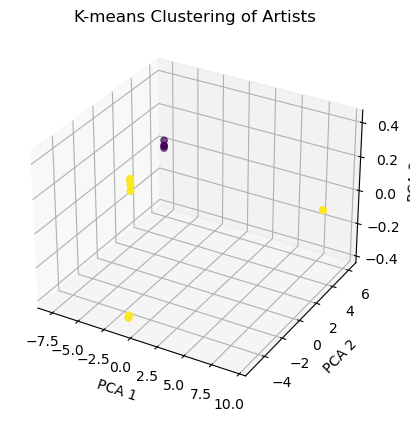

In [7]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  


kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data)

# Assigning cluster labels to a variable
clusters = kmeans.labels_

# Now, when plotting, 'clusters' is already defined
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=clusters, cmap='viridis', marker='o')


ax.set_title('K-means Clustering of Artists')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()


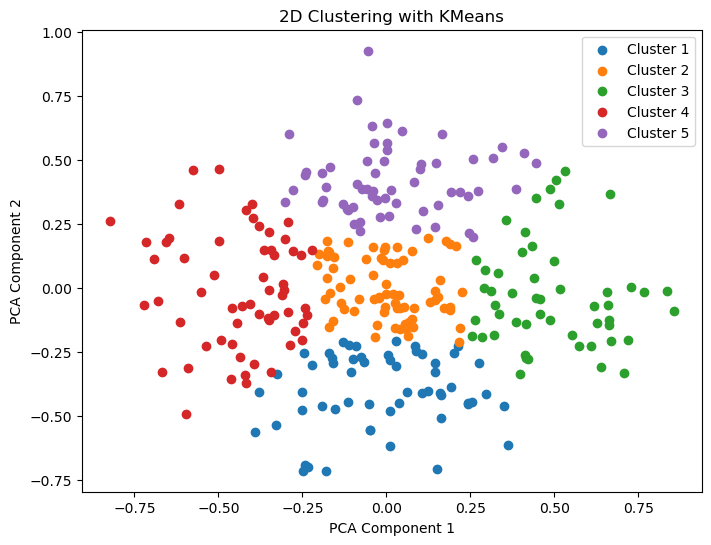

Number of points in Cluster 1: 57
Number of points in Cluster 2: 71
Number of points in Cluster 3: 52
Number of points in Cluster 4: 60
Number of points in Cluster 5: 60


In [8]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Sample data generation (replace this with your actual data)
# Let's assume your data is a 2D array where each row is a data point and columns are the features
np.random.seed(42)  # For reproducible results
data = np.random.rand(300, 5)  # 300 data points with 5 features each

# Reduce data to 2 dimensions using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Perform KMeans clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(reduced_data)

# Get the cluster assignments for each point
clusters = kmeans.labels_

# Plot the clustered data
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    # Select only data points that belong to the current cluster
    cluster_data = reduced_data[clusters == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i+1}')

plt.title('2D Clustering with KMeans')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Print the number of points in each cluster
for i in range(n_clusters):
    print(f'Number of points in Cluster {i+1}:', sum(clusters == i))


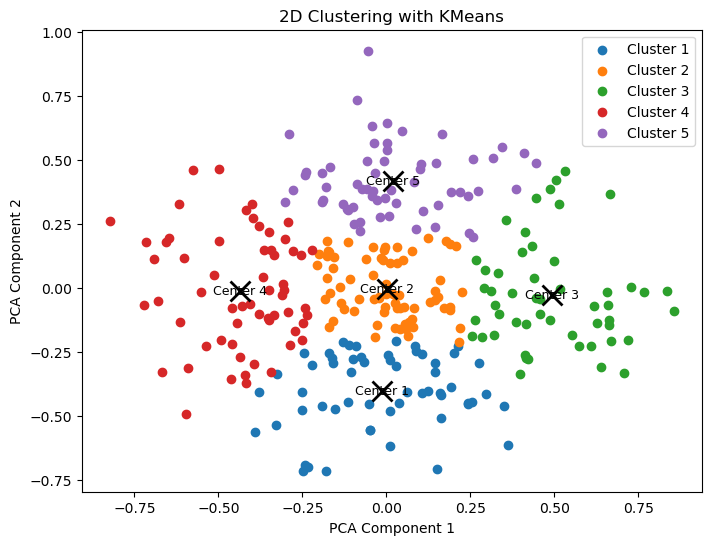

Number of points in Cluster 1: 57
Number of points in Cluster 2: 71
Number of points in Cluster 3: 52
Number of points in Cluster 4: 60
Number of points in Cluster 5: 60


In [13]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data = np.random.rand(300, 5)  # 300 data points with 5 features each

# Reduce data to 2 dimensions using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Perform KMeans clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(reduced_data)

# Get the cluster assignments for each point
clusters = kmeans.labels_

# Calculate the centroids of each cluster
centroids = kmeans.cluster_centers_

# Plot the clustered data
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    # Select only data points that belong to the current cluster
    cluster_data = reduced_data[clusters == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i+1}')
    # Plot the centroid for each cluster
    plt.plot(centroids[i, 0], centroids[i, 1], 'kx', markersize=15, markeredgewidth=2)

    # Optionally, label the centroids
    plt.text(centroids[i, 0], centroids[i, 1], f'Center {i+1}', fontsize=9, ha='center', va='center')

plt.title('2D Clustering with KMeans')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Print the number of points in each cluster
for i in range(n_clusters):
    print(f'Number of points in Cluster {i+1}:', sum(clusters == i))


In [18]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data = documents

# Reduce data to 2 dimensions using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Perform KMeans clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(reduced_data)

# Get the cluster assignments for each point
clusters = kmeans.labels_

# Plot the clustered data
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    # Select only data points that belong to the current cluster
    cluster_data = reduced_data[clusters == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i+1}')

# Annotating each document
for i, point in enumerate(reduced_data):
    plt.text(point[0], point[1], str(i), fontsize=8, ha='right', va='bottom')
# For each point in the cluster, add a text label
#for point, label in zip(cluster_data, np.array(labels)[clusters == i]):
#        plt.text(point[0], point[1], label, fontsize=9)
        
plt.title('2D Clustering with KMeans and Document Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Print the number of points in each cluster
for i in range(n_clusters):
    print(f'Number of points in Cluster {i+1}:', sum(clusters == i))


TypeError: float() argument must be a string or a real number, not 'dict'

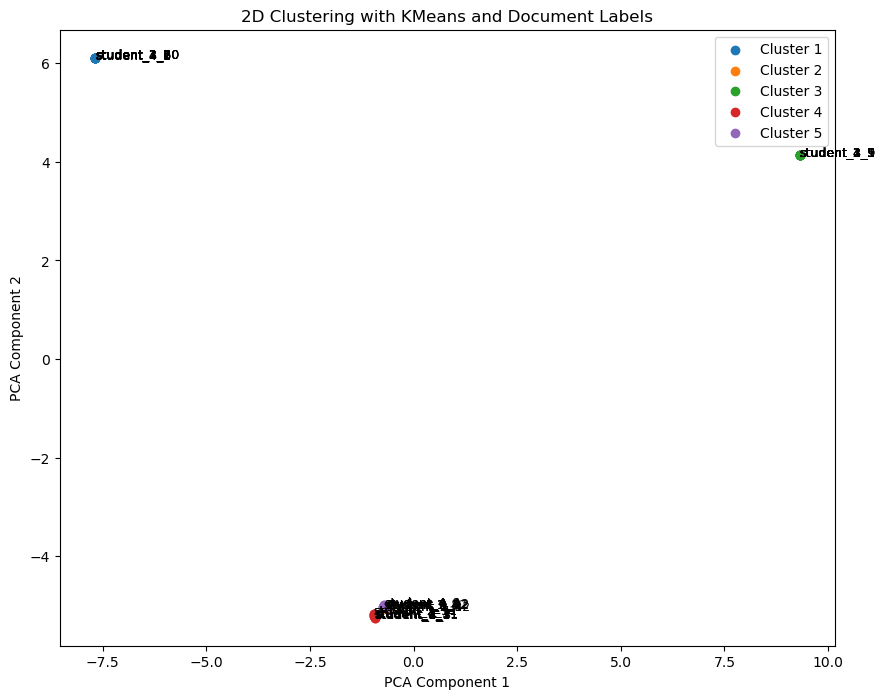

In [16]:
data_dict = documents
labels = list(data_dict.keys())
data = np.array(list(data_dict.values()))

# Reduce data to 2 dimensions using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Perform KMeans clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(reduced_data)

# Get the cluster assignments for each point
clusters = kmeans.labels_

# Plot the clustered data
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    # Select only data points that belong to the current cluster
    cluster_data = reduced_data[clusters == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i+1}')
    
    # For each point in the cluster, add a text label
    for point, label in zip(cluster_data, np.array(labels)[clusters == i]):
        plt.text(point[0], point[1], label, fontsize=9)

plt.title('2D Clustering with KMeans and Document Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

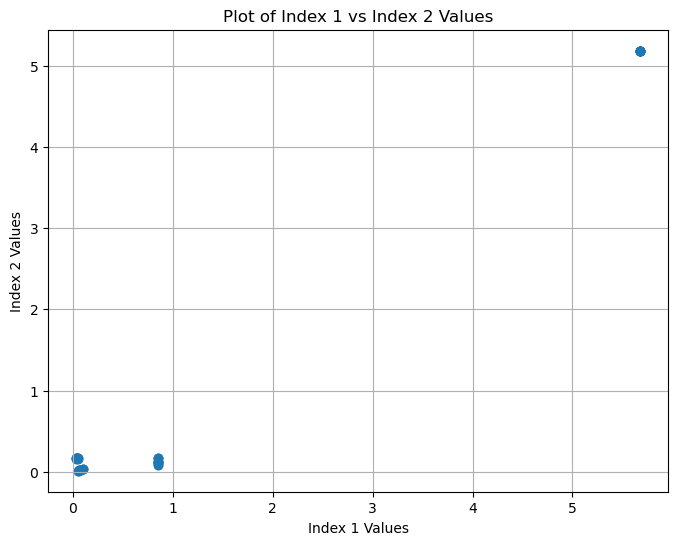

In [25]:
data = np.array(list(data_dict.values()))
index_1_values = data[:, 3]  # This selects all rows (:) from column at index 1
index_2_values = data[:, 2]  # This selects all rows (:) from column at index 2

# Plotting index 1 vs index 2
plt.figure(figsize=(8, 6))
plt.scatter(index_1_values, index_2_values)

plt.title('Plot of Index 1 vs Index 2 Values')
plt.xlabel('Index 1 Values')
plt.ylabel('Index 2 Values')
plt.grid(True)
plt.show()

In [28]:
data = documents
# Prepare data for analysis
features_dict = {}
for key, values in data.items():
    # Extract the writer group, e.g., 'student_4'
    group = '_'.join(key.split('_')[:2])
    
    # Aggregate values by group
    if group not in features_dict:
        features_dict[group] = []
    features_dict[group].append(values)

# Calculate mean and variance for each feature in each group
results = {}
for group, values in features_dict.items():
    arr = np.array(values)
    mean = np.mean(arr, axis=0)
    variance = np.var(arr, axis=0)
    
    results[group] = {'mean': mean, 'variance': variance}

# Display the results
for group, stats in results.items():
    print(f"Group: {group}")
    print(f"Mean: {stats['mean']}")
    print(f"Variance: {stats['variance']}\n")

Group: student_4
Mean: [ 2.16280779  3.59634327  1.3622139   1.65465145 -2.78048697]
Variance: [ 8.44090222 20.98478088  4.87083039  5.49749034 23.77698418]

Group: student_3
Mean: [ 2.14078604  3.60872277  1.3732157   1.65923242 -2.77360235]
Variance: [ 8.52095154 20.8988289   4.84316327  5.48285055 23.81578886]

Group: student_2
Mean: [ 2.11117048  3.62413578  1.38718487  1.6695238  -2.7665611 ]
Variance: [ 8.63624436 20.79249156  4.80794313  5.45017169 23.85528608]

Group: student_1
Mean: [ 2.15156315  3.60307758  1.36951045  1.65637786 -2.76457404]
Variance: [ 8.48116308 20.93788154  4.85250203  5.4920033  23.86701351]



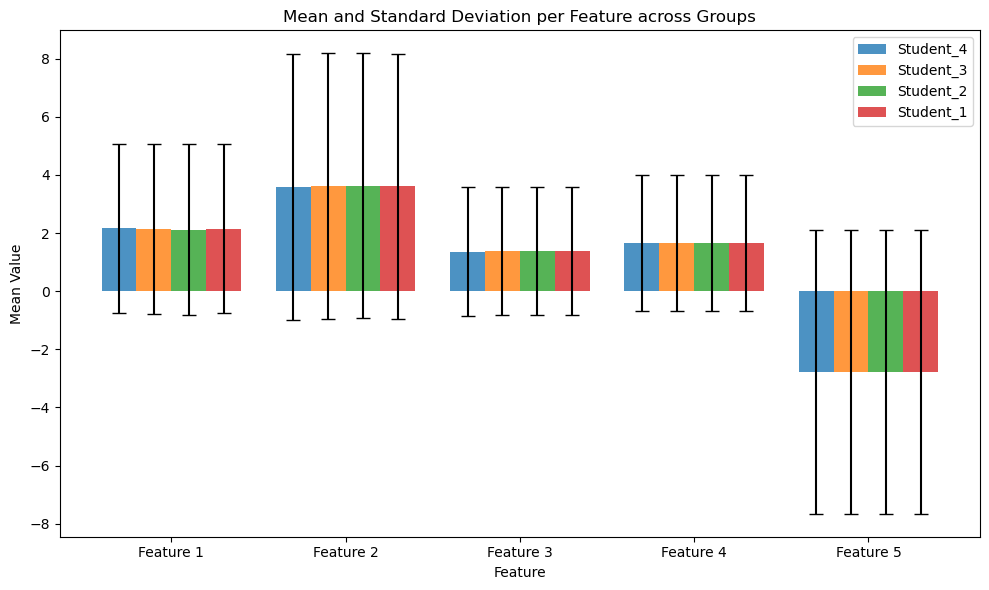

In [31]:
mean_values = []
variance_values = []

for group, values in features_dict.items():
    mean = np.mean(values, axis=0)
    variance = np.var(values, axis=0)
    mean_values.append(mean)
    variance_values.append(variance)

mean_values = np.array(mean_values)
variance_values = np.array(variance_values)
std_devs = np.sqrt(variance_values)

# Plot setup
n_groups = mean_values.shape[1]
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(mean_values.shape[0]):
    ax.bar(index + i * bar_width, mean_values[i], bar_width, alpha=opacity, label=f'Student_{len(features_dict)-i}',
           yerr=std_devs[i], capsize=5)

ax.set_xlabel('Feature')
ax.set_ylabel('Mean Value')
ax.set_title('Mean and Standard Deviation per Feature across Groups')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5'])
ax.legend()

plt.tight_layout()
plt.show()

IndexError: list index out of range

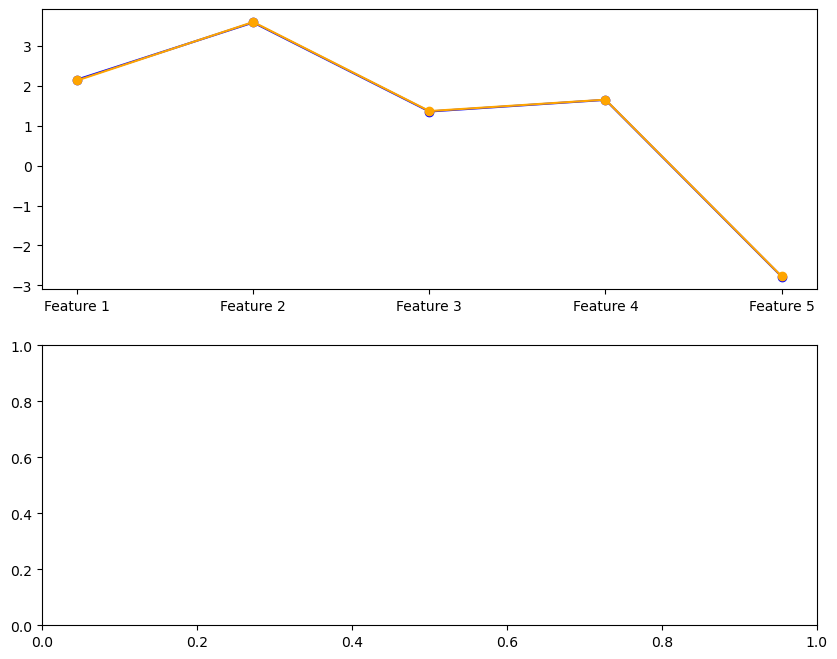

In [29]:
std_devs = np.sqrt(variance_values)

# Plot setup
n_groups = mean_values.shape[1]
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(mean_values.shape[0]):
    ax.bar(index + i * bar_width, mean_values[i], bar_width, alpha=opacity, label=f'Student_{4-i}',
           yerr=std_devs[i], capsize=5)

ax.set_xlabel('Feature')
ax.set_ylabel('Mean Value')
ax.set_title('Mean and Standard Deviation per Feature across Groups')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5'])
ax.legend()

plt.tight_layout()
plt.show()